# The Task at Hand

Have you ever wondered if computers could translate languages? Did you think google translate or duolingo worked because they memorized answers? 

The type of problem that translation solves is sequence to sequence. For instance, we could convert an english input sequence to a german output sequence. 

In this activity, we will create an english -> chinese translator and apply what we've been learning about LSTMs & RNNs.

## Preparing the data
We need to import our packages and data to learn a little bit about the problem at hand.

In [1]:
import numpy as np
import torch.nn as nn
from nltk.tokenize import WordPunctTokenizer
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from Word2Sequence import Word2Sequence
from Dataset import Dataset
from Seq2Seq import Seq2Seq

In [2]:
# read small_en-cn.txt file
data_path = './eng-chin.txt'
df = pd.read_table(data_path,header=None).iloc[:,:]
df = df.drop([2],axis=1)
df.columns=['english','chinese']

input_texts = df.english.values.tolist() #this will be all of the english sentences
target_texts = df.chinese.values.tolist() #this will be all of the chinese sentences

In [5]:
'''
Your code here: Try printing some english and chinese sentences from their lists input_texts and target_texts!
'''


print(input_texts[0])
print(target_texts[0])

Does any other country fan the flames of patriotism as much as America?
有没有一个国家比美国更提倡爱国主义？


In [9]:
#read in our model object. Tokenize our data
tk = WordPunctTokenizer()
english = [tk.tokenize(sentence.lower()) for sentence in input_texts]
chinese = [[x for x in sentence] for sentence in target_texts]

In [12]:
'''
Your code here: Explore this data. Can you calculate the maximum length of a sequence in each dataset english and chinese?
'''

# calculate max_len of any sequence in 'english' list and save it to a variable called max_english_length 

max_english_length = 0

for i in range(len(english)):
    if len(english[i]) > max_english_length:
        max_english_length = len(english[i])
print(max_english_length)
# calculate max_len of any sequence in 'chinese' list and save it to a variable called max_chinese_length
max_chinese_length = 0

for i in range(len(chinese)):
    if len(chinese[i]) > max_chinese_length:
        max_chinese_length = len(chinese[i])
print(max_chinese_length)

25
39


In [17]:
input_tokenizer = Word2Sequence()
for words in english:
    input_tokenizer.fit(words)
input_tokenizer.build_vocab(min=1, max_features=None) #inpu

output_tokenizer = Word2Sequence()
for words in chinese:
    output_tokenizer.fit(words)
output_tokenizer.build_vocab(min=1, max_features=None)

'''
Your code here: print the total english words in your input tokenizer and total chinese words in your output tokenizer below!
'''

print(len(input_tokenizer))
print(len(output_tokenizer))

199
317


<h1>Creating the model</h1>

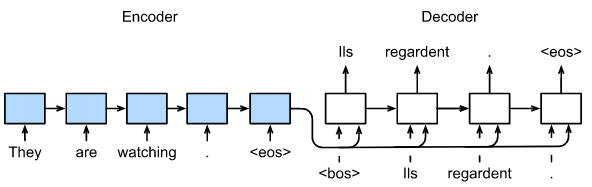

NOTE: For Structure of Encoder Inputs, they can all be either (assume all have same maxlen): 

1. \<SOS>, word1, word2, word3, ..., \<EOS>
2. word1, word2, word3, ..., \<EOS> 
3. word1, word2, word3, ...

NOTE: But Decoder In and Out structures should always look like this (assume all have same maxlen):

- Decoder Input: \<SOS>, word1, word2, word3, ...
- Decoder Output: word1, word2, word3, ..., \<EOS>  

This means that our input and ouput max length should be one more than the sequence's max length.

WHY? Data Structure:

- 1. Encoder Input: [word1, word2, ... + <EOS>]
- 2. Decoder Input: [<SOS> + word1, word2, ...]
- 3. Decoder Output:[word1, word2, ... + <EOS>]
    

nn docs - https://pytorch.org/docs/stable/nn.html



In [20]:
# Seq2Seq Parameters
in_maxlen = max_english_length + 1 # 25 + 1(<EOS> token)
out_maxlen = max_chinese_length + 1 # 39 + 1(<EOS> token or <SOS> token)
n_hidden = 32 # number of "neurons" per layer
d_model = 64 # number of embedding dimensions to represent each word
enc_n_class = len(input_tokenizer.dict) # OR... vocab size of englisth -> 199
dec_n_class = len(output_tokenizer.dict) # OR... vocab size of chinese -> 317
batch_size = 1

In [21]:
eng_maxlen = max_english_length + 1 # 25 + 1(<EOS> token)
chin_maxlen = max_chinese_length + 1  # 39 + 1(<EOS> token or <SOS> token)
batch_size = 1 

# Setup the Dataset.
dataset = Dataset(
    X = english,
    Y = chinese,
    in_tknz = input_tokenizer, out_tknz = output_tokenizer,
    in_maxlen = eng_maxlen, out_maxlen = chin_maxlen
)

'''
The following are helper functions to help pytorch. You won't need to know this much.
'''
# NOTE: collate_fn preprocesses your input from PyTorch Dataset above during PyTorch DataLoader
def collate_fn(batch):
    '''
    param batch: ([enc_in, dec_in, dec_out]， [enc_in, dec_in, dec_out], output of getitem...)
    '''
    # unpack values
    enc_in, dec_in, dec_out = list(zip(*batch))
    # Return tensor type
    return torch.LongTensor(enc_in), torch.LongTensor(dec_in), torch.LongTensor(dec_out)

def get_dataloader(dataset, batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn):
    '''
    Returns a way to access and use the data
    '''
    dataloader = DataLoader(dataset=dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            collate_fn=collate_fn)
    return dataloader
# Get PyTorch DataLoader
dataloader = get_dataloader(dataset, batch_size)
dataloader = get_dataloader(dataset, batch_size)

In [22]:
model = Seq2Seq(
    in_maxlen = in_maxlen,
    out_maxlen = out_maxlen,
    n_hidden = n_hidden,
    enc_n_class = len(input_tokenizer.dict),
    dec_n_class = len(output_tokenizer.dict),
    d_model = d_model,
    num_layers = 1,
)
model.to(device)
# # If you have saved a model before
# model.load_state_dict(torch.load("seq2seq.pt", map_location=device))

/projects/820ea3ac-497c-43fd-9cb7-abe34292faa8/miniconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Seq2Seq(
  (encoder): GRU(64, 32, dropout=0.3)
  (decoder): GRU(64, 32, dropout=0.3)
  (embed_enc): Embedding(199, 64)
  (embed_dec): Embedding(317, 64)
  (fc): Linear(in_features=32, out_features=317, bias=True)
)

In [24]:
# Define Loss and Optimizer -- these are ways we define performance for our model. If you're curious: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

<h1>Training our model</h1>

In [45]:
'''
Your code here: change the number of epochs to see how it effects training time and quality 
'''
epochs = 300


'''
Training -- no need to touch the code below.
'''
torch.cuda.empty_cache()
model.train()
model.to(device)
loss_records = []


for epoch in range(epochs):
    # runs the model and calculates loss
    loss = 0
    for _, (enc_in, dec_in, dec_out) in enumerate(dataloader):
        # enc_h_0.shape: [1(num_layers), 1(batch_size), 32(hidden_size)]
        enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
        # To Cuda Device if available
        enc_in, dec_in = enc_in.to(device), dec_in.to(device)
        
        pred = model(enc_in, enc_h_0, dec_in)
        
        dec_out = dec_out.to(device)
        for i in range(len(dec_out)): # dec_in.shape: [1(b), 40(out_maxlen)]
            # pred[i].shape: [40(out_maxlen), 317(dec_n_class)]
            # dec_out[i].shape: [40(out_maxlen)]
            loss += criterion(pred[i], dec_out[i])

    if (epoch) % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")

    if (epoch) % 100 == 0:
        loss_records.append(loss)
    
    # runs the actual back propacation
    optim.zero_grad()
    loss.backward()
    optim.step()
    torch.save(model.state_dict(), "seq2seq.pt")

Epoch: 0, Loss: 15.76434326171875


KeyboardInterrupt: 

## Let's check out our model's progress

No need to change the code below, this will plot our loss over time. How do you think we can tweak our code to decrease loss even further?



In [26]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points): # Helper function for showing our plots
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

<Figure size 432x288 with 0 Axes>

Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


Locator attempting to generate 2738 ticks ([51.6, ..., 599.0]), which exceeds Locator.MAXTICKS (1000).


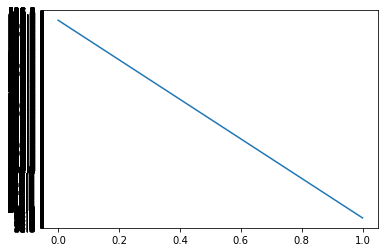

In [27]:
showPlot([loss.cpu().item() for loss in loss_records])

<h1>Code for Translating with our Model</h1>
This is where the Seq2Seq happens after the model is trained.


In [31]:
'''
No need to touch this code: 
'''

def translate(eng_sent, model, device):
    # set up the inputs and variables
    model.eval()
    model.to(device)
    eng_sent = tk.tokenize(eng_sent.lower()) + ["<EOS>"]
    eng_sent = input_tokenizer.transform(eng_sent, max_len=in_maxlen, pad_first=False)
    dec_in = (["<SOS>"] + ["<PAD>"]*out_maxlen)[:out_maxlen]
    dec_in = output_tokenizer.transform(dec_in, max_len=out_maxlen, pad_first=False)
    
    enc_h_0 = model.init_enc_hidden_GRU(batch_size, device)
    eng_sent, dec_in = torch.LongTensor(eng_sent), torch.LongTensor(dec_in)

    eng_sent = eng_sent.unsqueeze(0)
    dec_in = dec_in.unsqueeze(0)
    eng_sent, dec_in = eng_sent.to(device), dec_in.to(device)

    # run the model
    with torch.no_grad():
        # eng_sent: [1(b), 26(in_maxlen)]
        embedded_X = model.embed_enc(eng_sent)
        # embedded_X: [26(in_maxlen), 1(b), 64(d_model)] <- [1(b), 26(in_maxlen), 64(d_model)]
        embedded_X = embedded_X.permute(1, 0, 2)
        _, memory = model.encoder(embedded_X, enc_h_0)
        pred_loc = 0
        for i in range(out_maxlen-1):
            embedded_Y = model.embed_dec(dec_in)
            embedded_Y = embedded_Y.permute(1, 0, 2)
            outputs, _ = model.decoder(embedded_Y, memory)
            outputs = outputs.permute(1, 0, 2)
            pred = model.fc(outputs)
            pred = pred[0][pred_loc].topk(1)[1].item()
            pred_loc += 1
            if pred == 2:
                dec_in[0][pred_loc] = pred
                break
            else:
                dec_in[0][pred_loc] = pred
    return dec_in

# Using our Model in Practice
Check out these examples below. This is how you can translate sequences!

In [37]:
import random
eng_sents = random.sample(input_texts, 5)
for sent in eng_sents:
    translated = translate(sent, model, torch.device("cpu"))
    translated_sent = output_tokenizer.inverse_transform(translated[0], is_tensor=True)
    translated_sent = "".join([word for word in translated_sent if word != "<SOS>" and word != "<EOS>"and word != "<PAD>"])
    print(f"{sent} -> \n{translated_sent}")

Tom can write almost like a native speaker, but his pronunciation is terrible. -> 
<UNK><UNK><UNK><UNK><UNK>八公的<UNK><UNK>位。
His scores are always better than mine, even though he doesn't study very much. -> 
他的分数总比我高，尽管他学习得少一点。
I'd like to know the phone number of the nearest American Express office. -> 
我想知道最<UNK>的美國<UNK>通<UNK>事<UNK>的電話<UNK><UNK>。


It was not until I had a baby myself that I knew what mother's love is. -> 
直到我自己有了孩子我才明<UNK>了什么是母爱。
Tom can't account for his whereabouts on the day that Mary was murdered. -> 
汤姆不能说明玛丽<UNK><UNK>那天自己在哪里。


# Your turn!
Can you use the code in the cell above to translate custom sentences? 

In [34]:
'''
Your code here: translate custom sentences using the code above. Hint: You won't need a for loop!
'''


"\nYour code here: translate custom sentences using the code above. Hint: You won't need a for loop!\n"

In [52]:
sent = input()
translated = translate(sent, model, torch.device("cpu"))
translated_sent = output_tokenizer.inverse_transform(translated[0], is_tensor=True)
translated_sent = "".join([word for word in translated_sent if word != "<SOS>" and word != "<EOS>"and word != "<PAD>"])
print(f"{sent} -> \n{translated_sent}")

 This is a sentence

This is a sentence -> 
如果一个人有11只羊，<UNK>了9只之外，其他全<UNK><UNK>了，那么他还<UNK>下几只羊<UNK>？
